In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy
from geopy.geocoders import Nominatim
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns

#import pylab as pl
import pandas as pd
import numpy as np
#from get_jsonparsed_data import get_jsonparsed_data
import json
import os
from shapely.geometry import Point
from fiona.crs import from_epsg


%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
listings_df = gpd.read_file('gdfListingsAllYearByZip.geojson')

In [5]:
listings_df.head()

,bcode,note,zip,listing,geometry
0,36061,None,10001,126,POLYGON ((-74.00368400000001 40.74835500003317...
1,36061,None,10002,217,POLYGON ((-73.99694700000001 40.71207200003317...
2,36061,None,10003,190,POLYGON ((-73.99206100000001 40.72564200003317...
3,36061,None,10004,3,"(POLYGON ((-74.026658 40.68571500003317, -74.0..."
4,36061,None,10005,21,"POLYGON ((-74.009029 40.70531000003317, -74.00..."


In [7]:
listings_df.crs

{'init': u'epsg:4326'}

In [59]:
#testdf.crs = from_epsg(4326)
#testdf['geometry'] = testdf['geometry'].to_crs(epsg=4326)


In [8]:
from __future__ import division, print_function
# Copyright. 2017. Daniel Lewis, Federica Bianco.
# https://github.com/danlewis85/cartogrampy/blob/master/LICENSE

def prop_symbols(gdf, value_field, geom_field='geometry', symbol='circle', scale_factor=10, position='centroid',
                 edgecolors='k', facecolors='b', alpha=0.5):
    """Returns proportional symbols for a given GeoPandas GeoDataFrame value field as a Matplotlib PatchCollection
    Args:
        gdf (geopandas.geodataframe.GeoDataFrame): Input GeoDataFrame.
        value_field (str): Field name of values to be used to produce proportional symbols.
        geom_field (str, optional): Field name of geometry column in input GeoDataFrame, defaults to 'geometry'.
        symbol (str or int, optional): Name of proportional symbol to be created, defaults to 'circle', options available:
            'circle' - inputs accepted: 'circle' (case insensitive),'c','C', 1
            'triangle' - inputs accepted: 'triangle' (case insensitive),'t','T','Tri' (case insensitive),'3', 3
            'square' - inputs accepted: 'square' (case insensitive),'sq','s','S','4', 4
            'pentagon' - inputs accepted: 'pentagon' (case insensitive),'p','P','Pent' (case insensitive),'5', 5
            'hexagon' - inputs accepted: 'hexagon' (case insensitive),'h','H','hex' (case insensitive),'6', 6
            'heptagon' - inputs accepted: 'heptagon','septagon' (case insensitive),'hept' (case insensitive),'sept' (case insensitive),'7', 7
            'octagon' - inputs accepted: 'octagon' (case insensitive)','oct' (case insensitive),'8', 8
            'nonagon' - inputs accepted: 'nonagon' (case insensitive),'non' (case insensitive),'9', 9
            'decagon' - inputs accepted: 'decagon' (case insensitive),'dec' (case insensitive),'10',10
            'rhombus' - inputs accepted: 'rhombus' (case insensitive),'r','R'
            'lozenge' - inputs accepted: 'lozenge' (case insensitive),'l','L'
            'pentagram' - inputs accepted: 'pentagram' (case insensitive)
            'hexagram' - inputs accepted: 'hexagram' (case insensitive)
        scale_factor (numeric, optional): Arbitary Int or Float constant value to scale proportional symbols.
        position (str, optional): Center position of proportional symbols, defaults to centroid.
            'centroid' - GeoDataFrame centroid property, shape centroid.
            'center' - Centroid of GeoDataFrame envelope (bounding box) property, envelope centroid.
            'representative point' - Point returned by GeoDataFrame represntative point method, guarenteed to be inside polygon.
        edgepointlors (str, optional): Matplotlib color (defaults to black 'k')
        facecolors (str, optional): Matplotlib color (defaults to blue 'b')
        alpha (str, optional): Transparency (defaults to 0.5)
    Returns:
        Matplotlib PatchCollection of proportional Symbols
    """

    # Required matplotlib and numpy classes/functions for patch and collection
    # creation.
    from matplotlib.patches import Circle, RegularPolygon, Rectangle, Polygon
    from matplotlib.collections import PatchCollection
    from numpy import power, sin, tan, cos, pi

    # Calculate proportional symbol positions based on
    if position.lower() in ['centroid']:
        cents = gdf[geom_field].apply(
            lambda x: [x.centroid.x, x.centroid.y]).tolist()
    elif position.lower() in ['center', 'centre']:
        cents = gdf[geom_field].envelope.apply(
            lambda x: [x.centroid.x, x.centroid.y]).tolist()
    elif position.lower() in ['representative point', 'rep']:
        cents = gdf[geom_field].representative_point().apply(
            lambda x: [x.x, x.y]).tolist()
    else:
        # If position parameter not recognised, default to centroid.
        print("position parameter invalid, using 'centroid'. Options are 'centroid','center', or 'representative point'")
        cents = gdf[geom_field].apply(
            lambda x: [x.centroid.x, x.centroid.y]).tolist()

    symbol = str(symbol).lower()
    
    # Big if, elif, else statement to differentiate symbol choice.
    if symbol in ['circle', 'c', '1']:
        # Work out circular symbol radii
        radii = power(gdf[value_field] / pi, 0.5) * scale_factor
        # Create patches based on radii
        patches = [Circle(cents[i], radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['triangle', 't', 'tri', '3']:
        # Work out (equilateral) triangle radius (circumradius)
        radii = power((gdf[value_field] * 12.0) /
                      (9.0 * power(3.0, 0.5)), 0.5) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 3, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['square', 'sq', 's', '4']:
        # Work out square symbol side lengths
        side = power(gdf[value_field], 0.5) * scale_factor
        # Create patches based on side length
        patches = [Rectangle((cents[i][0] - side[i] / 2.0, cents[i][1] -
                              side[i] / 2.0), side[i], side[i]) 
                   for i in range(len(side))]

    elif symbol in ['pentagon', 'p', 'pent', '5']:
        # work out pentagon radius
        radii = power(
            (4.0 * tan(pi / 5.0) * gdf[value_field]) /
            5.0, 0.5) / (2.0 * sin(pi / 5.0)) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 5, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['hexagon', 'h', 'hex','6']:
        # work out hexagon radius
        radii = power(
            (4.0 * tan(pi / 6.0) * gdf[value_field]) /
            6.0, 0.5) / (2.0 * sin(pi / 6.0)) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 6, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['heptagon', 'septagon', 'hept', 'sept', '7']:
        # work out heptagon/septagon radius
        radii = power(
            (4.0 * tan(pi / 7.0) * gdf[value_field]) /
            7.0, 0.5) / (2.0 * sin(pi / 7.0)) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 7, radius=radii[i])
                   for i in range(len(radii))]

    # NB decided not to allow 'o' as often denotes a circle
    elif symbol in ['octagon', 'oct', '8']:
        # work out octogon radius
        radii = power(
            (4.0 * tan(pi / 8.0) * gdf[value_field]) /
            8.0, 0.5) / (2.0 * sin(pi / 8.0)) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 8, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['nonagon', 'non', '9']:
        # work out nonagon radius
        radii = power(
            (4.0 * tan(pi / 9.0) * gdf[value_field]) /
            9.0, 0.5) / (2.0 * sin(pi / 9.0)) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 9, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['decagon', 'dec', '10']:
        # work out decagon radius
        radii = power((4.0 * tan(pi / 10.0) * gdf[value_field]) / 10.0, 0.5) / (
            2.0 * sin(pi / 10.0)) * scale_factor
        # Create patches based on radii
        patches = [RegularPolygon(cents[i], 10, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['rhombus', 'r']:
        # Assume diagonals are equal - is this technically a rhombus?
        radii = power(gdf[value_field] / 2.0, 0.5) * scale_factor
        # Create patches based on radii length
        patches = [RegularPolygon(cents[i], 4, radius=radii[i])
                   for i in range(len(radii))]

    elif symbol in ['lozenge', 'l']:
        # Assume acute angle is 30 degrees
        diag1 = power((2.0 * gdf[value_field]) / (power(3, 0.5) / 3.0), 0.5)
        diag2 = diag1 * (power(3, 0.5) / 3.0)
        diag1 = diag1 * scale_factor
        diag2 = diag2 * scale_factor
        xy = [[[cents[i][0] - diag2[i] / 2.0, cents[i][1]],
               [cents[i][0], cents[i][1] + diag1[i] / 2.0], 
               [cents[i][0] + diag2[i] / 2.0, cents[i][1]], 
               [cents[i][0], cents[i][1] - diag1[i] / 2.0]] for i in range(len(diag1))]
        # Create patches
        patches = [Polygon(xy[i]) for i in range(len(xy))]

    elif symbol in ['pentagram']:
        rad = power(gdf[value_field] /
                    ((10.0 * tan(pi / 10.0)) /
                     (3.0 - power(pi / 10.0, 2.0))), 0.5)
        h = 2.0 * ((gdf[value_field] / 10.0) / rad)
        s = h / sin(18.0 * pi / 180.0)
        rad *= scale_factor
        h *= scale_factor
        s *= scale_factor
        # Manually figure out vertex positions.
        xy = []
        for j in range(len(rad)):
            v0 = [cents[j][0], cents[j][1] + rad[j]]
            v1 = [cents[j][0] + h[j], cents[j]
                  [1] + h[j] / tan(36.0 * pi / 180.0)]
            v2 = [cents[j][0] + h[j] + s[j], cents[j]
                  [1] + h[j] / tan(36.0 * pi / 180.0)]
            v3 = [v2[0] - s[j] * sin(54.0 * pi / 180.0),
                  v2[1] - s[j] * cos(54.0 * pi / 180.0)]
            v4 = [cents[j][0] + rad[j] * sin(36.0 * pi / 180.0),
                  cents[j][1] - rad[j] * cos(36.0 * pi / 180.0)]
            v5 = [cents[j][0], cents[j][1] - h[j] / sin(36.0 * pi / 180.0)]
            v6 = [cents[j][0] - rad[j] * sin(36.0 * pi / 180.0),
                  cents[j][1] - rad[j] * cos(36.0 * pi / 180.0)]
            v8 = [cents[j][0] - h[j] - s[j], cents[j]
                  [1] + h[j] / tan(36.0 * pi / 180.0)]
            v7 = [v8[0] + s[j] * sin(54.0 * pi / 180.0),
                  v8[1] - s[j] * cos(54.0 * pi / 180.0)]
            v9 = [cents[j][0] - h[j], cents[j]
                  [1] + h[j] / tan(36.0 * pi / 180.0)]
            xy.append([v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v0])
        patches = [Polygon(xy[i]) for i in range(len(xy))]

    elif symbol in ['hexagram']:
        s = power(gdf[value_field] / 3.0 * power(3, 0.5), 0.5)
        h = 2.0 * power(0.75 * power(s, 2), 0.5)
        s *= scale_factor
        h *= scale_factor
        # Manually figure out vertex positions
        xy = []
        for j in range(len(s)):
            v0 = [cents[j][0], cents[j][1] + h[j]]
            v1 = [cents[j][0] + s[j] / 2.0, cents[j][1] + h[j] / 2.0]
            v2 = [cents[j][0] + 1.5 * s[j], cents[j][1] + h[j] / 2.0]
            v3 = [cents[j][0] + s[j], cents[j][1]]
            v4 = [cents[j][0] + 1.5 * s[j], cents[j][1] - h[j] / 2.0]
            v5 = [cents[j][0] + s[j] / 2.0, cents[j][1] - h[j] / 2.0]
            v6 = [cents[j][0], cents[j][1] - h[j]]
            v7 = [cents[j][0] - s[j] / 2.0, cents[j][1] - h[j] / 2.0]
            v8 = [cents[j][0] - 1.5 * s[j], cents[j][1] - h[j] / 2.0]
            v9 = [cents[j][0] - s[j], cents[j][1]]
            v10 = [cents[j][0] - 1.5 * s[j], cents[j][1] + h[j] / 2.0]
            v11 = [cents[j][0] - s[j] / 2.0, cents[j][1] + h[j] / 2.0]
            xy.append([v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v0])
        patches = [Polygon(xy[i]) for i in range(len(xy))]

    else:
        print("symbol parameter invalid, using 'circle', use help(propsymbols) for all options")
        # Work out circular symbol radii
        radii = (power(gdf[value_field] / pi, 0.5) * scale_factor).tolist()
        # Create patches based on radii
        patches = [Circle(cents[i], radius=radii[i])
                   for i in range(len(radii))]

    return PatchCollection(
        patches, zorder=10, edgecolors=edgecolors, facecolors=facecolors, alpha=alpha)


In [10]:
circles = prop_symbols(listings_df, 'listing', 'geometry', 'circle', .001)

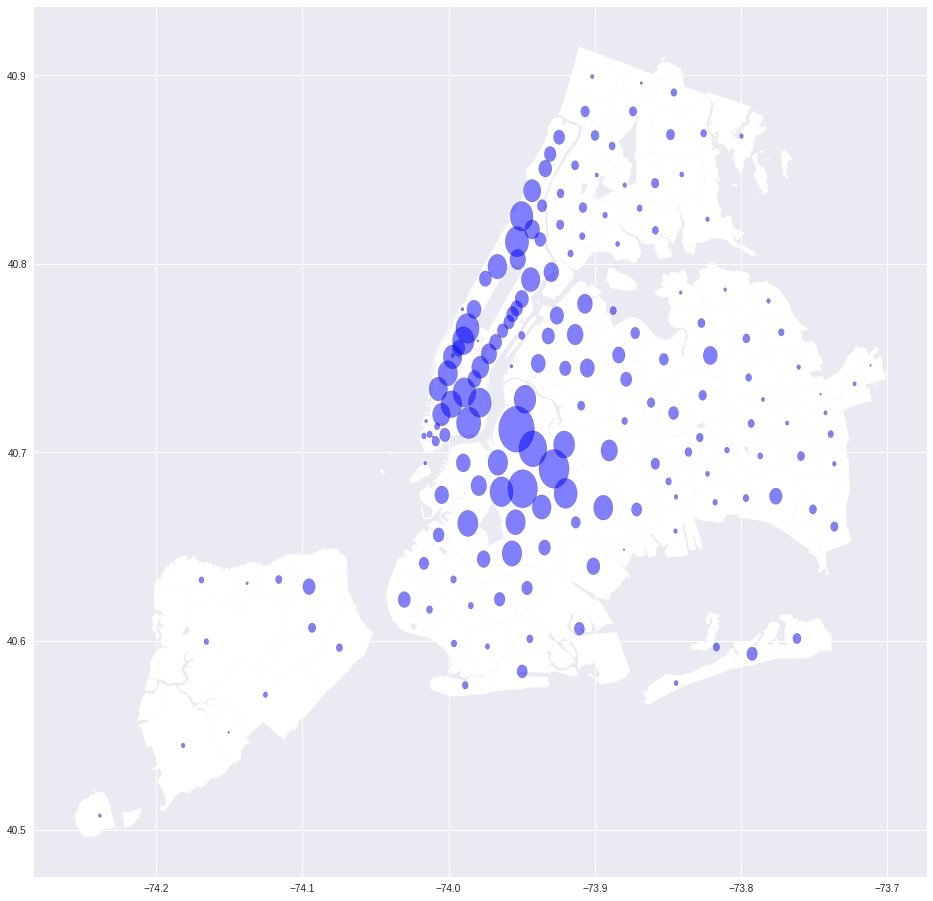

In [11]:
fig, ax  = plt.subplots(figsize=(16, 16))
testdf.plot(color='w', ax=ax)
ax.add_collection(circles)

In [12]:
usstate = listings_df

In [13]:
usstate = usstate.rename(columns={'listing': 2015})

(-74.283647900000119,
 -73.673084099999826,
 40.474961350033162,
 40.936249650033169)

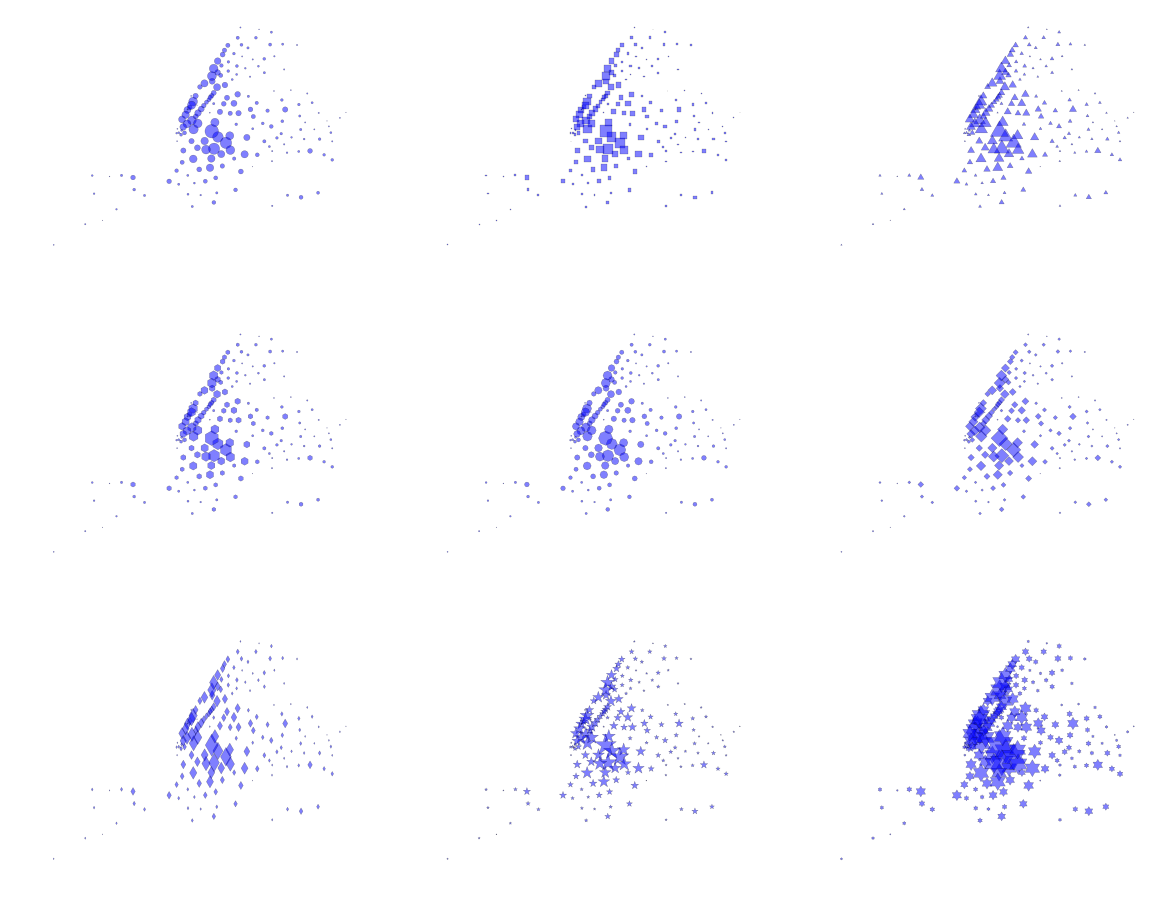

In [15]:
# Plot symbols on map
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 16))

# ax1
circles = prop_symbols(usstate, 2015, 'geometry', 'circle', .001)
usstate.plot(color='w', ax=ax1, zorder=0)
ax1.add_collection(circles)
ax1.axis('equal')
ax1.axis('off')

# ax2
squares = prop_symbols(usstate, 2015, 'geometry', 'square', .001)
usstate.plot(color='w', ax=ax2, zorder=0)
ax2.add_collection(squares)
ax2.axis('equal')
ax2.axis('off')

# ax3
triangles = prop_symbols(usstate, 2015, 'geometry', 'triangle', .001)
usstate.plot(color='w', ax=ax3, zorder=0)
ax3.add_collection(triangles)
ax3.axis('equal')
ax3.axis('off')

# ax4
hexagons = prop_symbols(usstate, 2015, 'geometry', 'hexagon', .001)
usstate.plot(color='w', ax=ax4, zorder=0)
ax4.add_collection(hexagons)
ax4.axis('equal')
ax4.axis('off')

# ax5
octagons = prop_symbols(usstate, 2015, 'geometry', 'octagon', .001)
usstate.plot(color='w', ax=ax5, zorder=0)
ax5.add_collection(octagons)
ax5.axis('equal')
ax5.axis('off')

# ax6
rhombuses = prop_symbols(usstate, 2015, 'geometry', 'rhombus', .001)
usstate.plot(color='w', ax=ax6, zorder=0)
ax6.add_collection(rhombuses)
ax6.axis('equal')
ax6.axis('off')

# ax7
lozenges = prop_symbols(usstate, 2015, 'geometry', 'lozenge', .001)
usstate.plot(color='w', ax=ax7, zorder=0)
ax7.add_collection(lozenges)
ax7.axis('equal')
ax7.axis('off')

# ax8
pentagrams = prop_symbols(usstate, 2015, 'geometry', 'pentagram', .001)
usstate.plot(color='w', ax=ax8, zorder=0)
ax8.add_collection(pentagrams)
ax8.axis('equal')
ax8.axis('off')

# ax9
hexagrams = prop_symbols(usstate, 2015, 'geometry', 'hexagram', .001)
usstate.plot(color='w', ax=ax9, zorder=0)
ax9.add_collection(hexagrams)
ax9.axis('equal')
ax9.axis('off')


In [28]:
usstate.head()

,bcode,note,zip,2015,geometry
0,36061,None,10001,126,POLYGON ((-74.00368400000001 40.74835500003317...
1,36061,None,10002,217,POLYGON ((-73.99694700000001 40.71207200003317...
2,36061,None,10003,190,POLYGON ((-73.99206100000001 40.72564200003317...
3,36061,None,10004,3,"(POLYGON ((-74.026658 40.68571500003317, -74.0..."
4,36061,None,10005,21,"POLYGON ((-74.009029 40.70531000003317, -74.00..."


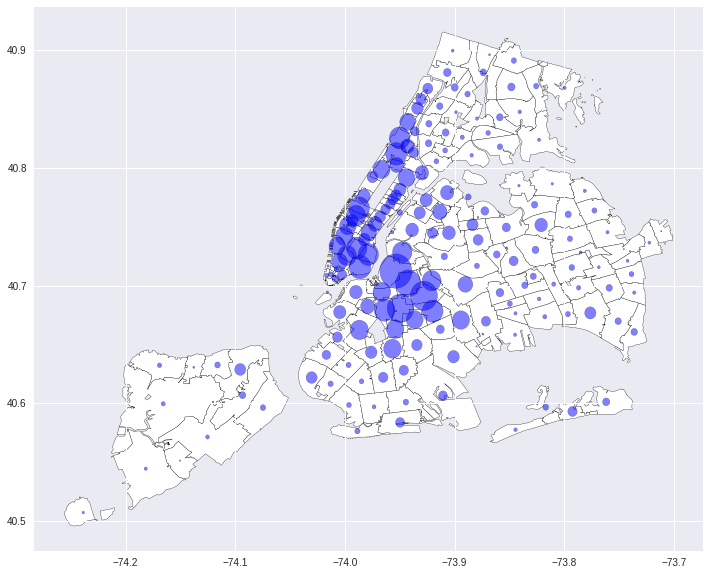

In [16]:
fig, ax = plt.subplots(figsize=(12,10))
circles = prop_symbols(usstate, 2015, 'geometry', 'circle', .0012)
usstate.plot(color='w', ax=ax, edgecolor='black',zorder=0)
ax.add_collection(circles)


In [17]:
hotels_df = pd.read_csv('ALL_Hotels_by_ZIP.csv')

In [20]:
hotels_df.head()

,GEO.id,zip,GEO.display-label,NAICS.id,NAICS.display-label,RCPSZFE.id,RCPSZFE.display-label,YEAR.id,ESTAB
0,8610000US10001,10001,"ZIP 10001 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,33
1,8610000US10002,10002,"ZIP 10002 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,11
2,8610000US10003,10003,"ZIP 10003 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,12
3,8610000US10004,10004,"ZIP 10004 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,2
4,8610000US10005,10005,"ZIP 10005 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,4


In [19]:
hotels_df = hotels_df.rename(columns={'Zipcode': 'zip'})

In [48]:
listings_df.dtypes

bcode       object
note        object
zip          int64
listing      int64
geometry    object
dtype: object

In [45]:
hotels_df.dtypes

GEO.id                   object
zip                       int64
GEO.display-label        object
NAICS.id                  int64
NAICS.display-label      object
RCPSZFE.id                int64
RCPSZFE.display-label    object
YEAR.id                   int64
ESTAB                     int64
dtype: object

In [47]:
listings_df['zip'] = pd.to_numeric(listings_df['zip'])

In [51]:
hotels_v_listings = pd.merge(listings_df, hotels_df, on='zip', how='left')

In [52]:
hotels_v_listings.shape

(176, 13)

In [53]:
hotels_v_listings.head()

,bcode,note,zip,listing,geometry,GEO.id,GEO.display-label,NAICS.id,NAICS.display-label,RCPSZFE.id,RCPSZFE.display-label,YEAR.id,ESTAB
0,36061,None,10001,126,POLYGON ((-74.00368400000001 40.74835500003317...,8610000US10001,"ZIP 10001 (New York, NY)",7211.0,Traveler accommodation,1.0,All establishments,2012.0,33.0
1,36061,None,10002,217,POLYGON ((-73.99694700000001 40.71207200003317...,8610000US10002,"ZIP 10002 (New York, NY)",7211.0,Traveler accommodation,1.0,All establishments,2012.0,11.0
2,36061,None,10003,190,POLYGON ((-73.99206100000001 40.72564200003317...,8610000US10003,"ZIP 10003 (New York, NY)",7211.0,Traveler accommodation,1.0,All establishments,2012.0,12.0
3,36061,None,10004,3,"(POLYGON ((-74.026658 40.68571500003317, -74.0...",8610000US10004,"ZIP 10004 (New York, NY)",7211.0,Traveler accommodation,1.0,All establishments,2012.0,2.0
4,36061,None,10005,21,"POLYGON ((-74.009029 40.70531000003317, -74.00...",8610000US10005,"ZIP 10005 (New York, NY)",7211.0,Traveler accommodation,1.0,All establishments,2012.0,4.0


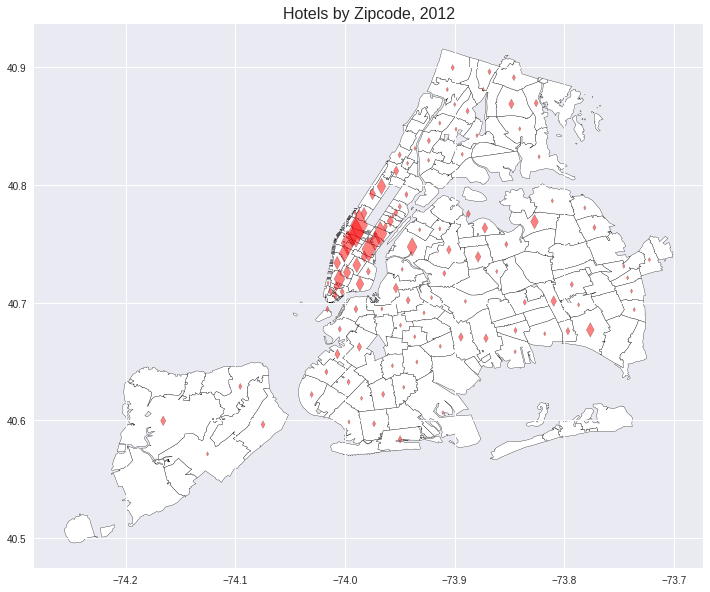

In [107]:
fig, ax = plt.subplots(figsize=(12,10))
#circles = prop_symbols(hotels_v_listings, 'listing', 'geometry', 'circle', .0012)
lozenges = prop_symbols(hotels_v_listings, 'ESTAB', 'geometry', 'lozenge', .002, facecolors='r')
hotels_v_listings.plot(color='w', ax=ax, edgecolor='black',zorder=0)
#ax.add_collection(circles)
ax.add_collection(lozenges)
ax.set_title('Hotels by Zipcode, 2012', size=16)

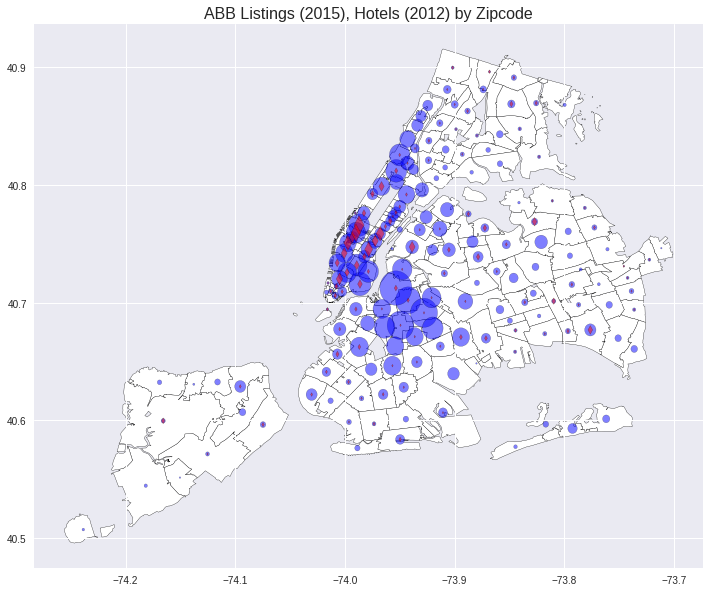

In [70]:
fig, ax = plt.subplots(figsize=(12,10))
circles = prop_symbols(hotels_v_listings, 'listing', 'geometry', 'circle', .0012)
lozenges = prop_symbols(hotels_v_listings, 'ESTAB', 'geometry', 'lozenge', .0012, facecolors='r')
hotels_v_listings.plot(color='w', ax=ax, edgecolor='black',zorder=0)
ax.add_collection(circles)
ax.add_collection(lozenges)
ax.set_title('ABB Listings (2015), Hotels (2012) by Zipcode', size=16)

In [71]:
hotel_sq_ft = pd.read_csv('LL84_self_reported_hotels.csv')

In [72]:
hotel_sq_ft.head()

,zip,hotel_count,total_ft_sq
0,10001,14,3708953
1,10002,2,179858
2,10003,3,364817
3,10005,1,100000
4,10006,1,329999


In [79]:
sq_ft_df = pd.merge(listings_df, hotel_sq_ft, on='zip', how='left')

In [82]:
sq_ft_df.head()

,bcode,note,zip,listing,geometry,hotel_count,total_ft_sq,hotel_sqft by listing
0,36061,None,10001,126,POLYGON ((-74.00368400000001 40.74835500003317...,14.0,3708953.0,29436.134921
1,36061,None,10002,217,POLYGON ((-73.99694700000001 40.71207200003317...,2.0,179858.0,828.838710
2,36061,None,10003,190,POLYGON ((-73.99206100000001 40.72564200003317...,3.0,364817.0,1920.089474
3,36061,None,10004,3,"(POLYGON ((-74.026658 40.68571500003317, -74.0...",NaN,NaN,NaN
4,36061,None,10005,21,"POLYGON ((-74.009029 40.70531000003317, -74.00...",1.0,100000.0,4761.904762


In [81]:
sq_ft_df['hotel_sqft by listing'] =  sq_ft_df.total_ft_sq / sq_ft_df.listing

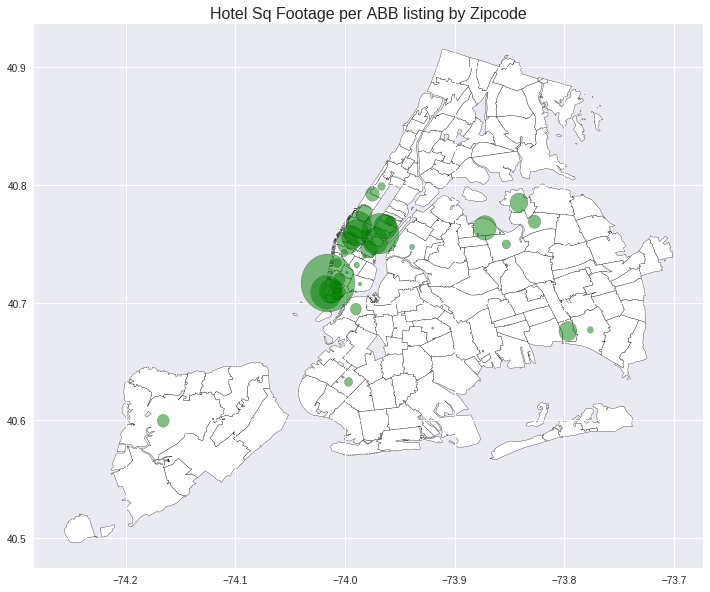

In [88]:
fig, ax = plt.subplots(figsize=(12,10))
circles = prop_symbols(sq_ft_df, 'hotel_sqft by listing', 'geometry', 'circle', .0001, facecolors='g')
#lozenges = prop_symbols(hotels_v_listings, 'ESTAB', 'geometry', 'lozenge', .0012, facecolors='r')
sq_ft_df.plot(color='w', ax=ax, edgecolor='black',zorder=0)
ax.add_collection(circles)
#ax.add_collection(lozenges)
ax.set_title('Hotel Sq Footage per ABB listing by Zipcode', size=16)

In [93]:
sq_ft_df['sq_mi_area'] = sq_ft_df.to_crs(epsg=2263).geometry.area/(2.788*10**7)

In [127]:
sq_ft_df.head()

,bcode,note,zip,listing,geometry,hotel_count,total_ft_sq,hotel_sqft by listing,area,sq_mi_area,hotel_sq_mi,hotel_sq_mi_density,log_listing_count,log_hotel_sq_dens
0,36061,None,10001,126,POLYGON ((-74.00368400000001 40.74835500003317...,14.0,3708953.0,29436.134921,0.000172,0.621352,0.133033,0.214102,2.100371,-0.669379
1,36061,None,10002,217,POLYGON ((-73.99694700000001 40.71207200003317...,2.0,179858.0,828.838710,0.000243,0.879359,0.006451,0.007336,2.336460,-2.134529
2,36061,None,10003,190,POLYGON ((-73.99206100000001 40.72564200003317...,3.0,364817.0,1920.089474,0.000159,0.576412,0.013085,0.022701,2.278754,-1.643951
3,36061,None,10004,3,"(POLYGON ((-74.026658 40.68571500003317, -74.0...",NaN,NaN,NaN,0.000154,0.559690,NaN,NaN,0.477121,NaN
4,36061,None,10005,21,"POLYGON ((-74.009029 40.70531000003317, -74.00...",1.0,100000.0,4761.904762,0.000020,0.073514,0.003587,0.048790,1.322219,-1.311665


In [95]:
sq_ft_df['hotel_sq_mi'] = sq_ft_df.total_ft_sq/(2.788*10**7)

In [97]:
sq_ft_df['hotel_sq_mi_density'] = sq_ft_df.hotel_sq_mi / sq_ft_df.sq_mi_area

In [116]:
import math

In [118]:
sq_ft_df.dtypes

bcode                     object
note                      object
zip                        int64
listing                    int64
geometry                  object
hotel_count              float64
total_ft_sq              float64
hotel_sqft by listing    float64
area                     float64
sq_mi_area               float64
hotel_sq_mi              float64
hotel_sq_mi_density      float64
dtype: object

In [128]:
sq_ft_df['log_listing_count'] = np.log10(sq_ft_df['listing'])
sq_ft_df['log_hotel_sq_dens'] = np.log10(sq_ft_df['hotel_sq_mi_density']*100)


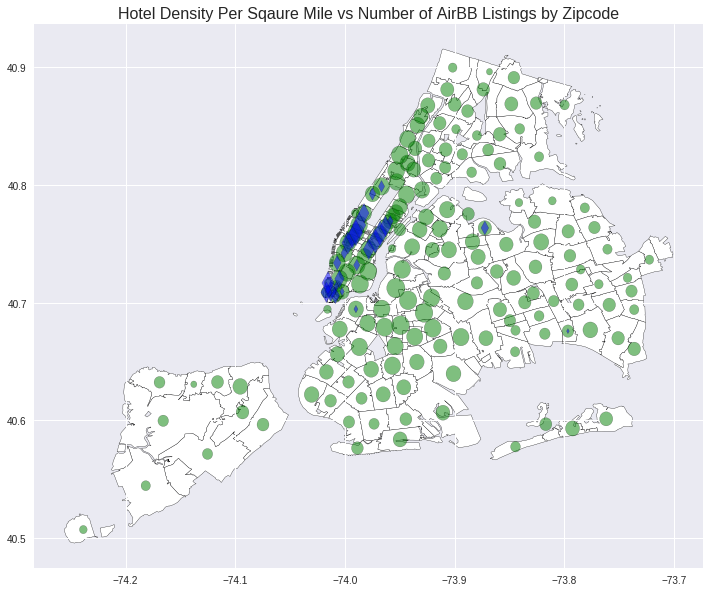

In [132]:
fig, ax = plt.subplots(figsize=(12,10))
circles = prop_symbols(sq_ft_df, 'log_listing_count', 'geometry', 'circle', .009, facecolors='g')
lozenges = prop_symbols(sq_ft_df, 'log_hotel_sq_dens', 'geometry', 'lozenge', .009, facecolors='b')
sq_ft_df.plot(color='w', ax=ax, edgecolor='black',zorder=0)
ax.add_collection(circles)
ax.add_collection(lozenges)
ax.set_title('Hotel Density Per Sqaure Mile vs Number of AirBB Listings by Zipcode', size=16)